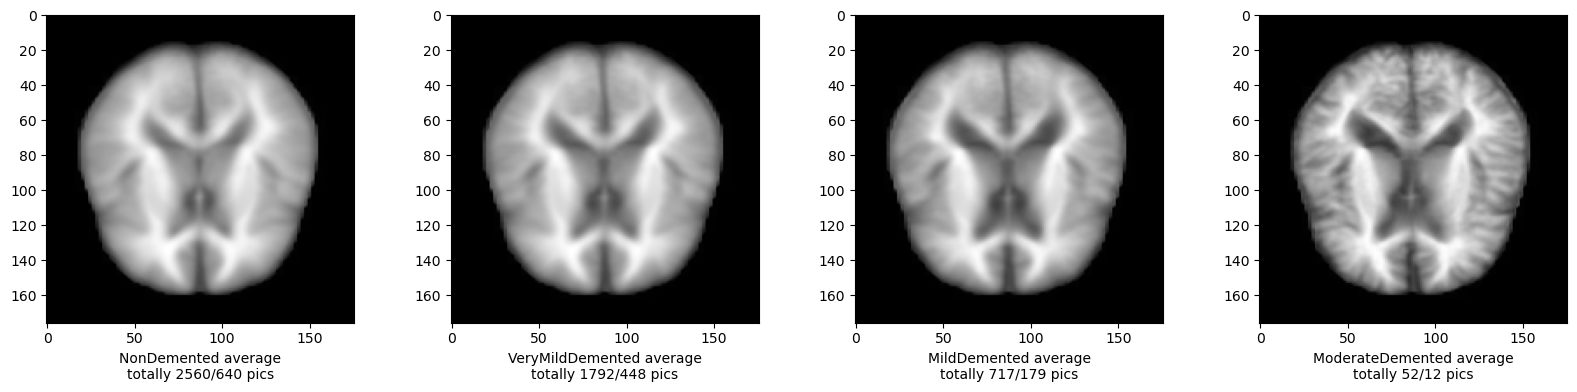

In [21]:
import numpy as np
import pandas as pd
import os
from PIL import Image

TRAIN_DIR = 'C:/Users/BHU/Pictures/New folder/train/'
TEST_DIR = 'C:/Users/BHU/Pictures/New folder/test/'
IMAGE_SIZE = 176
CLASSES = [
    'NonDemented',
    'VeryMildDemented',
    'MildDemented',
    'ModerateDemented',
]
train_images = {}
test_images = {}

for klass in CLASSES:
    train_images[klass] = []
    test_images[klass] = []

for klass in CLASSES:
    for image in os.listdir(TRAIN_DIR + klass):
        im = Image.open(TRAIN_DIR + klass + '/' + image).convert('L')
        train_images[klass].append(im.resize((IMAGE_SIZE, IMAGE_SIZE)))
        
    for image in os.listdir(TEST_DIR + klass):
        im = Image.open(TEST_DIR + klass + '/' + image).convert('L')
        test_images[klass].append(im.resize((IMAGE_SIZE, IMAGE_SIZE)))

from matplotlib import pyplot as plt

plt.figure(1, figsize=(20, 4))
i = 1
for klass in CLASSES:
    avg_pic = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
    for pic in train_images[klass] + test_images[klass]:
        avg_pic += np.array(pic)
    avg_pic = avg_pic / (len(train_images[klass]) + len(test_images[klass]))
    plt.subplot(1, 4, i)
    i += 1
    plt.imshow(avg_pic, cmap='gray')
    plt.xlabel('%s average\ntotally %d/%d pics' % (klass, len(train_images[klass]), len(test_images[klass])))
plt.show()

In [22]:
class_weight = {}
max_classes = len(test_images['NonDemented']) / 100
for i, klass in enumerate(CLASSES):
    class_weight[i] = max_classes / len(test_images[klass])
class_weight

{0: 0.01,
 1: 0.014285714285714287,
 2: 0.03575418994413408,
 3: 0.5333333333333333}

In [23]:
from keras.utils import np_utils
from skimage.exposure import equalize_adapthist as eq_hist

def equalize(im):
    return eq_hist(np.array(im), clip_limit=0.03)

train_data = np.array([equalize(i) for i in train_images[CLASSES[0]]])
train_labels = np.zeros((len(train_images[CLASSES[0]]), 1))
for ind, klass in enumerate(CLASSES[1:], start=1):
    klass_arr = np.array([equalize(i) for i in train_images[klass]])
    train_data = np.concatenate([train_data, klass_arr], axis=0)
    
    labels_arr = np.ones((len(train_images[klass]), 1)) * ind
    train_labels = np.concatenate([train_labels, labels_arr], axis=0)

test_data = np.array([equalize(i) for i in test_images[CLASSES[0]]])
test_labels = np.zeros((len(test_images[CLASSES[0]]), 1))
for ind, klass in enumerate(CLASSES[1:], start=1):
    klass_arr = np.array([equalize(i) for i in test_images[klass]])
    test_data = np.concatenate([test_data, klass_arr], axis=0)
    
    labels_arr = np.ones((len(test_images[klass]), 1)) * ind
    test_labels = np.concatenate([test_labels, labels_arr], axis=0)

    
train_data = train_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
test_data = test_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))

train_labels = np_utils.to_categorical(train_labels)
test_labels = np_utils.to_categorical(test_labels)

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((5121, 176, 176, 1), (5121, 4), (1279, 176, 176, 1), (1279, 4))

In [24]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

p = np.random.permutation(train_data.shape[0])
train_data = train_data[p]
train_labels = train_labels[p]

ros = RandomOverSampler(random_state=42)
train_ros_data, train_ros_labels = ros.fit_resample(train_data.reshape((-1, IMAGE_SIZE * IMAGE_SIZE)), train_labels)
test_ros_data, test_ros_labels = ros.fit_resample(test_data.reshape((-1, IMAGE_SIZE * IMAGE_SIZE)), test_labels)

train_ros_data = train_ros_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
test_ros_data = test_ros_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))

train_ros_data.shape, train_ros_labels.shape, test_ros_data.shape, test_ros_labels.shape

((10240, 176, 176, 1), (10240, 4), (2560, 176, 176, 1), (2560, 4))

In [25]:
from keras.callbacks import Callback
from keras import backend
from keras.models import load_model
import math

# this callback applies cosine annealing, saves snapshots and allows to load them
class SnapshotEnsemble(Callback):
    
    __snapshot_name_fmt = "snapshot_%d.hdf5"
    
    def __init__(self, n_models, n_epochs_per_model, lr_max, verbose=1):
        """
        n_models -- quantity of models (snapshots)
        n_epochs_per_model -- quantity of epoch for every model (snapshot)
        lr_max -- maximum learning rate (snapshot starter)
        """
        self.n_epochs_per_model = n_epochs_per_model
        self.n_models = n_models
        self.n_epochs_total = self.n_models * self.n_epochs_per_model
        self.lr_max = lr_max
        self.verbose = verbose
        self.lrs = []
 
    # calculate learning rate for epoch
    def cosine_annealing(self, epoch):
        cos_inner = (math.pi * (epoch % self.n_epochs_per_model)) / self.n_epochs_per_model
        return self.lr_max / 2 * (math.cos(cos_inner) + 1)

    # when epoch begins update learning rate
    def on_epoch_begin(self, epoch, logs={}):
        # update learning rate
        lr = self.cosine_annealing(epoch)
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrs.append(lr)

    # when epoch ends check if there is a need to save a snapshot
    def on_epoch_end(self, epoch, logs={}):
        if (epoch + 1) % self.n_epochs_per_model == 0:
            # save model to file
            filename = self.__snapshot_name_fmt % ((epoch + 1) // self.n_epochs_per_model)
            self.model.save(filename)
            if self.verbose:
                print('Epoch %d: snapshot saved to %s' % (epoch, filename))
                
    # load all snapshots after training
    def load_ensemble(self):
        models = []
        for i in range(self.n_models):
            models.append(load_model(self.__snapshot_name_fmt % (i + 1)))
        return models

In [26]:
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D, LeakyReLU
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import Adam

imagegen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=15,
    height_shift_range=15,
    zoom_range=0.2
)

def create_cnn(filters=[32], kernels=[3, 3, 5], dropout=0.5, denses=[128], reg=.0001):

    model = Sequential()
    
    for i, fil in enumerate(filters):
        if i == 0:
            model.add(Conv2D(fil, kernels[0], padding='same', kernel_regularizer=l2(reg), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
        else:
            model.add(Conv2D(fil, kernels[0], padding='same', kernel_regularizer=l2(reg)))
        model.add(LeakyReLU())
        
        for ker in kernels[1:]:
            model.add(BatchNormalization())
            model.add(Conv2D(fil, ker, padding='same', kernel_regularizer=l2(reg)))
            model.add(LeakyReLU())
            
        model.add(MaxPooling2D())
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Flatten())
    
    for den in denses:
        model.add(Dense(den, kernel_regularizer=l2(reg)))
        model.add(LeakyReLU())
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    
    model.add(Dense(len(CLASSES), activation='softmax'))
    
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(.001),
        metrics=['acc']
    )

    return model

In [ ]:
se_callback = SnapshotEnsemble(n_models=5, n_epochs_per_model=50, lr_max=.003)

model = create_cnn(filters=[32, 64, 128], kernels=[3, 3, 5], dropout=0.5, denses=[128, 64], reg=.0001)
history = model.fit(
    imagegen.flow(train_ros_data, train_ros_labels, batch_size=32),
    steps_per_epoch=len(train_ros_data) / 32,
    epochs=se_callback.n_epochs_total,
    verbose=0,
    callbacks=[se_callback],
    validation_data=(test_ros_data, test_ros_labels)
)

In [ ]:
h = history.history
plt.figure(1, figsize=(16, 10))

plt.subplot(121)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(h['loss'], label='training')
plt.plot(h['val_loss'], label='validation')
plt.legend()

plt.subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(h['acc'], label='training')
plt.plot(h['val_acc'], label='validation')
plt.legend()

plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

models = se_callback.load_ensemble()
def predict(models_ensemble, data):
    y_pred = np.zeros((data.shape[0], len(CLASSES)))
    for model in models_ensemble:
        y_pred += model.predict(data)
    y_pred = np.argmax(y_pred, axis=1)
    return y_pred

y_true = np.argmax(test_labels, axis=1)
y_pred = predict(models, test_data)

cm = confusion_matrix(y_true, y_pred)
print('F1s = %.3f; %.3f' % (f1_score(y_true, y_pred, average='micro'), f1_score(y_true, y_pred, average='macro')))

cm_norm = cm.copy().astype(float)
for i in range(cm_norm.shape[0]):
    cm_norm[i] = cm_norm[i] / cm_norm[i].sum() * 100

plt.figure(1, figsize=(14, 6))

plt.subplot(121)
plt.title('Confusion matrix')
sns.heatmap(pd.DataFrame(cm, index=CLASSES, columns=CLASSES), annot=True, fmt='d', cbar=False)

plt.subplot(122)
plt.title('Normalized confusion matrix')
sns.heatmap(pd.DataFrame(cm_norm, index=CLASSES, columns=CLASSES), annot=True, fmt='.1f', cbar=False)

plt.show()